![Memories Teach](https://lh3.google.com/u/2/d/11o4JyBYhHcmz-LSt63GpOs4lfW9j39T_=w1912-h954-iv1)


`Basic to Advance in Google colab's for image processing, pattern recognition and computer vision`

[Phonepaserth SISAYKEO]

Reference: visioncolab

# Example: Cow biometrics using SIFT

This example shows how to use SIFT to match two images. First it is shown how SIFT is used in general terms using a classical example*, and then it is shown how it can be used in a biometric application to recognize cows through their skin spots.

References:


* [Image Stitching Using OpenCV](https://towardsdatascience.com/image-stitching-using-opencv-817779c86a83) by Vagdevi Kommineni

* [SIFT's](https://www.dropbox.com/s/eph6v7vs5kvhac4/Lowe_SIFT.pdf?dl=0) by Lowe



# Setup

In [ ]:
# to run in google colab
import sys
if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())
    subprocess.call("wget https://raw.githubusercontent.com/YoniChechik/AI_is_Math/master/c_08_features/left.jpg".split())
    subprocess.call("wget https://raw.githubusercontent.com/YoniChechik/AI_is_Math/master/c_08_features/right.jpg".split())



## Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import stats

# 1. Basic Example: Matching in two images

In [ ]:
rgb_l  = cv2.cvtColor(cv2.imread("left.jpg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r  = cv2.cvtColor(cv2.imread("right.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)

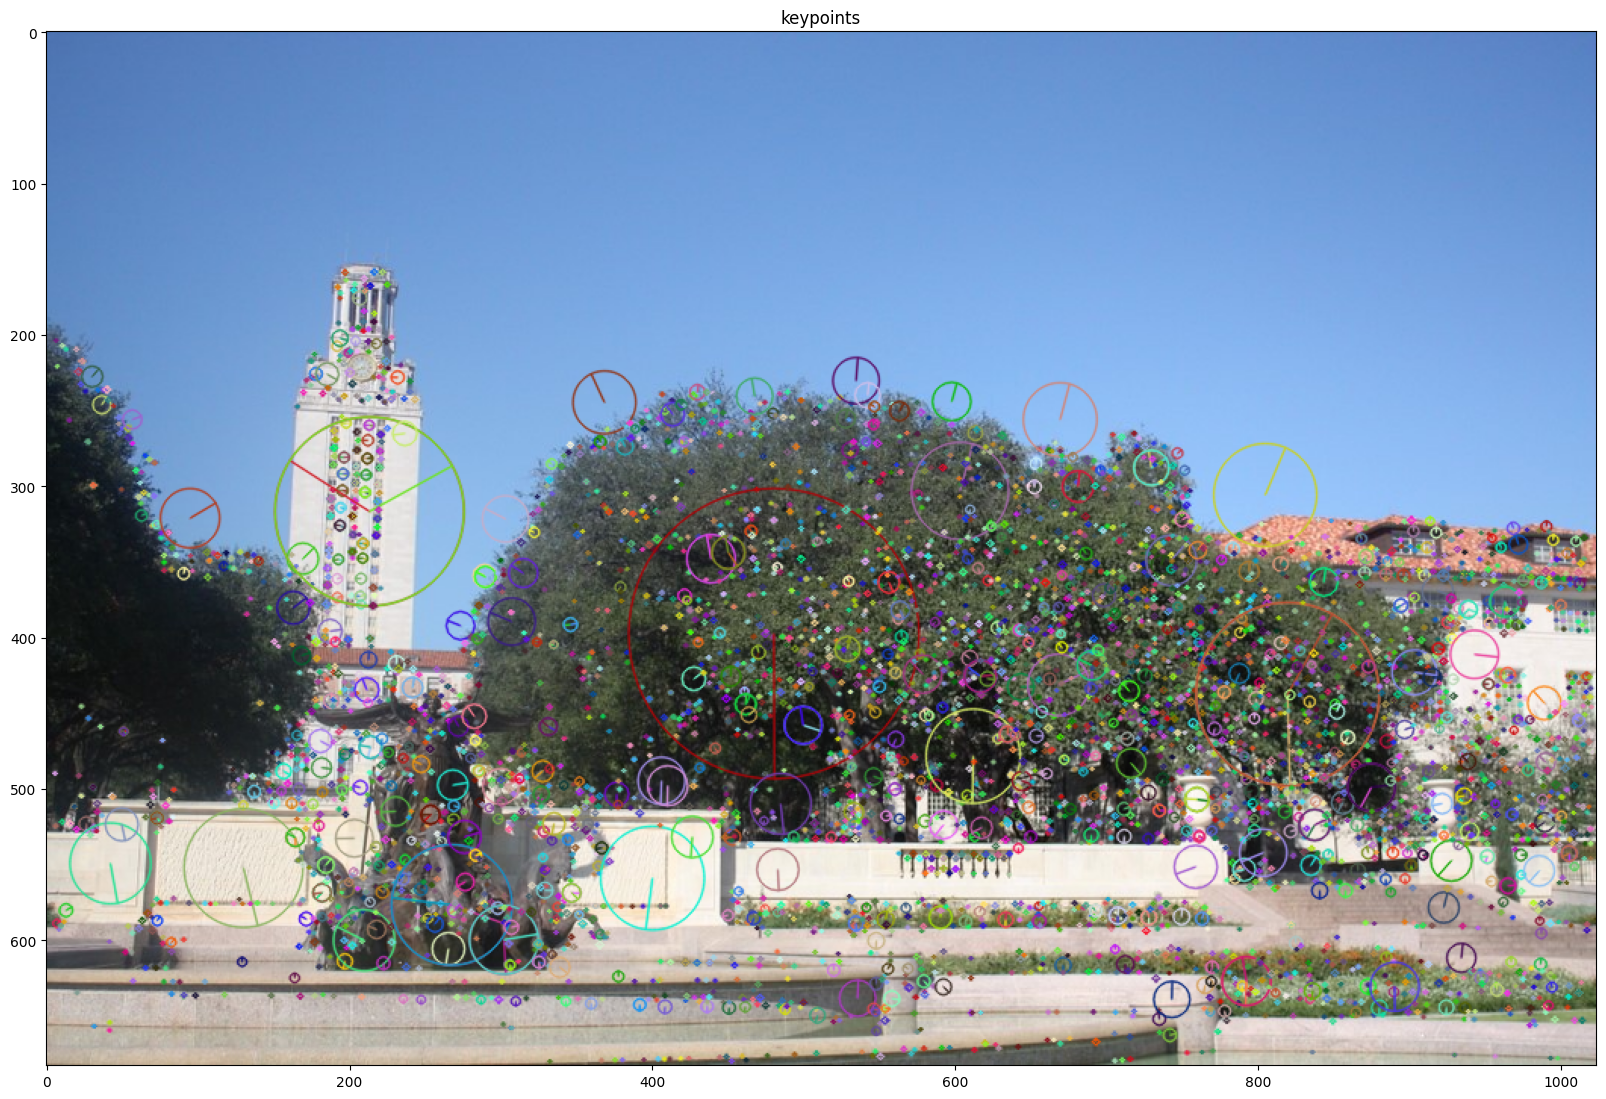

In [ ]:
# use orb if sift is not installed
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

test = cv2.drawKeypoints(rgb_l, kp_l, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

figsize = (20, 20)
plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()

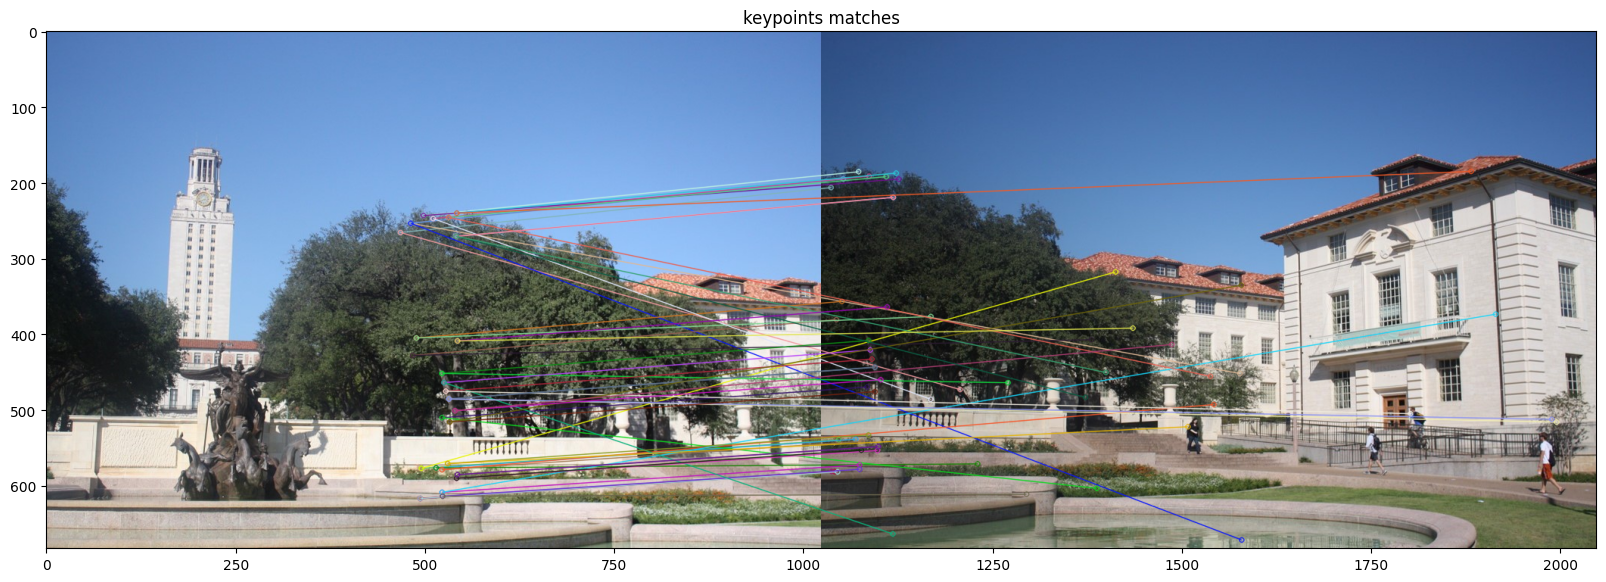

In [ ]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=2)

# Apply ratio test
good_match = []
for m in matches:
    if m[0].distance/m[1].distance < 0.5:
        good_match.append(m)
good_match_arr = np.asarray(good_match)

# show only 30 matches
im_matches = cv2.drawMatchesKnn(rgb_l, kp_l, rgb_r, kp_r,
                                good_match[0:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(im_matches)
plt.title("keypoints matches")
plt.show()



# 2. Cow Biometrics

## Database

This database consists of 80 images of cows. They are color images of 200 x 400 pixels.

In [ ]:
!wget https://www.dropbox.com/s/llw8sy4llylhg2q/cows.zip
!unzip -qq cows.zip

--2023-07-18 18:37:56--  https://www.dropbox.com/s/llw8sy4llylhg2q/cows.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/llw8sy4llylhg2q/cows.zip [following]
--2023-07-18 18:37:57--  https://www.dropbox.com/s/raw/llw8sy4llylhg2q/cows.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7492875664c27bb9ca86f6e2c9.dl.dropboxusercontent.com/cd/0/inline/CAFwf-S0QIsNPemQxB5wpPexKbj6gwdRXKs6ICQoKTuZ_6soM9g1h1FXwZlPQpH9jV2u05ap8XMmpXMoOWYPF060WmyZrBy_H1uWNJaRVtQP99HIkcJdWmmoVLr6cFH75AIObkBlSQqt6XW1WblS9qezkq1qveTYmF7Mrvy8VSPHAw/file# [following]
--2023-07-18 18:37:57--  https://uc7492875664c27bb9ca86f6e2c9.dl.dropboxusercontent.com/cd/0/inline/CAFwf-S0QIsNPemQxB5wpPexKbj6gwdRXKs6ICQoKTuZ_6soM9g1h1FXwZlPQpH9jV2u05ap8XMmpXMoOWYPF060W

In [ ]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def ImageLoad(prefix,num_img,echo='off'):
  st   = prefix + num2fixstr(num_img,5) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')

  img = cv2.cvtColor(cv2.imread(st), cv2.COLOR_BGR2RGB)
  return img


## Visualización de una vaca

loading image cows/V00004.png...


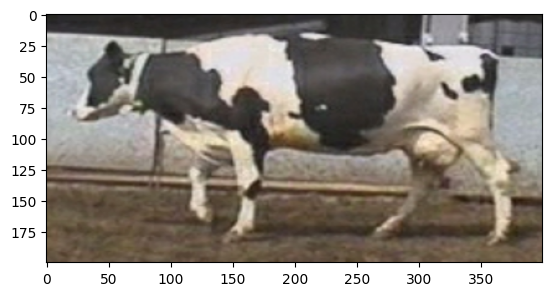

In [ ]:
I = ImageLoad('cows/V',4,echo='on')
plt.imshow(I,cmap='gray')
plt.show()

## Extraction of SIFT descriptors

The 128-element SIFT descriptor is extracted from all the keypoints of each image. This is about 400-500 keypoints per image. All keypoints, which in this example are 35910, are stored in an `X` array of 35910 x 128 elements. Additionally, each descriptor is stored in a normalized form (with norm = 1). At the same time, the number of the image from which the keypoint comes from is stored in the vector `y` of 35910 elements, i.e. this vector has a number between 0 and 79.

In [ ]:
t = 0
Xt = np.zeros((50000,128))
yt = np.zeros((50000,))

N = 80

for i in range(N):
  I = ImageLoad('cows/V',i+1,echo='on')
  J = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
  # SIFT extraction
  kp, desc = feature_extractor.detectAndCompute(J, None)
  ni = desc.shape[0]
  for j in range(ni):
    f = desc[j,:]
    Xt[t,:] =  f/np.linalg.norm(f)
    yt[t] = i
    t = t+1;

  print('... '+str(ni)+' descriptores have been extracted.')

X = Xt[0:t,:]
y = yt[0:t]
print('Total number of SIFT descriptors in '+str(N)+' images: '+str(t))

loading image cows/V00001.png...
... 424 descriptores have been extracted.
loading image cows/V00002.png...
... 404 descriptores have been extracted.
loading image cows/V00003.png...
... 338 descriptores have been extracted.
loading image cows/V00004.png...
... 492 descriptores have been extracted.
loading image cows/V00005.png...
... 406 descriptores have been extracted.
loading image cows/V00006.png...
... 469 descriptores have been extracted.
loading image cows/V00007.png...
... 460 descriptores have been extracted.
loading image cows/V00008.png...
... 442 descriptores have been extracted.
loading image cows/V00009.png...
... 459 descriptores have been extracted.
loading image cows/V00010.png...
... 418 descriptores have been extracted.
loading image cows/V00011.png...
... 544 descriptores have been extracted.
loading image cows/V00012.png...
... 490 descriptores have been extracted.
loading image cows/V00013.png...
... 357 descriptores have been extracted.
loading image cows/V00014

## Testing

The image most similar to the `itest` image is searched, i.e. the image (which is not the testing image) that contains the highest number of SIFT descriptors similar to the SIFT descriptors of the testing.

<ipython-input-10-677792c9e633>:33: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  m = stats.mode(d[kk])
<ipython-input-10-677792c9e633>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


loading image cows/V00004.png...
Testing Imag: 4


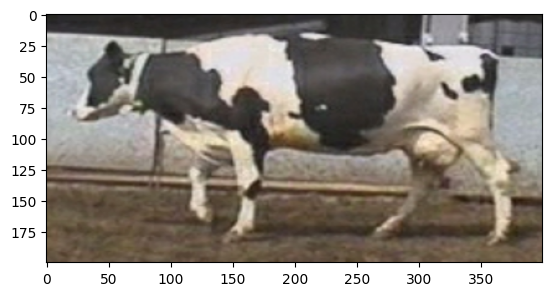

 
loading image cows/V00005.png...
For image 4, the most similar image is: 5.


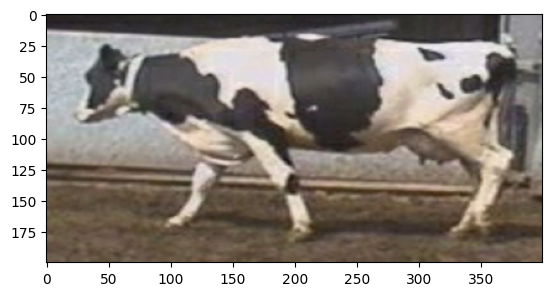

--------------------------------------------------
loading image cows/V00014.png...
Testing Imag: 14


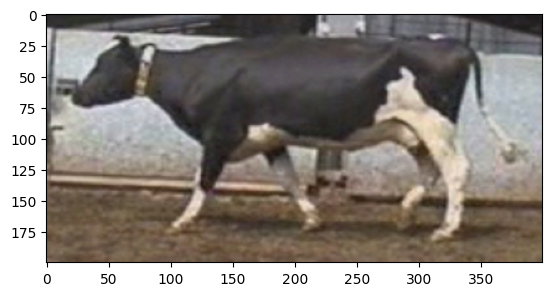

 
loading image cows/V00015.png...
For image 14, the most similar image is: 15.


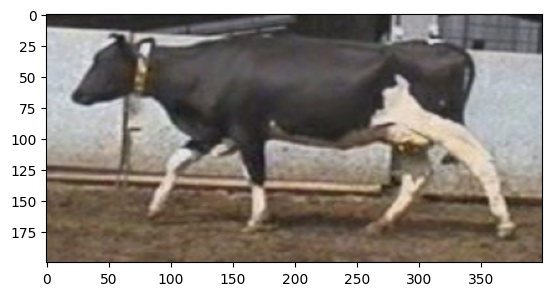

--------------------------------------------------
loading image cows/V00024.png...
Testing Imag: 24


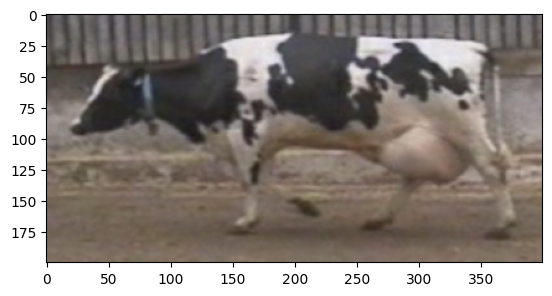

 
loading image cows/V00023.png...
For image 24, the most similar image is: 23.


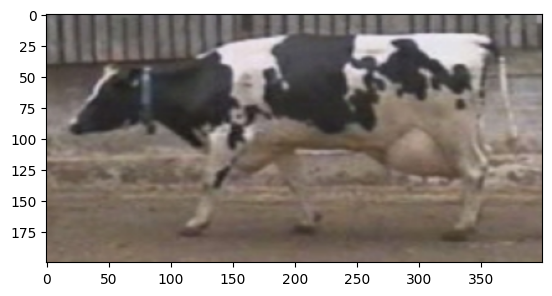

--------------------------------------------------
loading image cows/V00034.png...
Testing Imag: 34


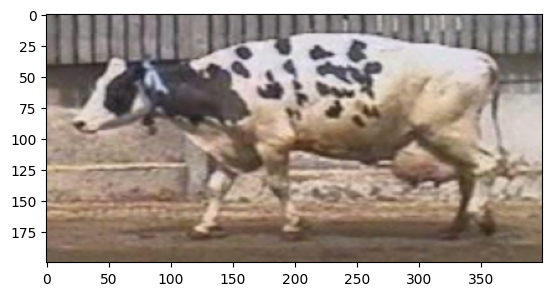

 
loading image cows/V00035.png...
For image 34, the most similar image is: 35.


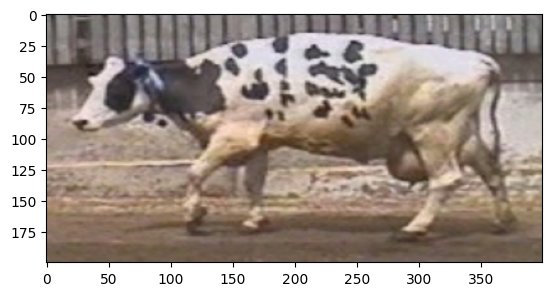

--------------------------------------------------
loading image cows/V00044.png...
Testing Imag: 44


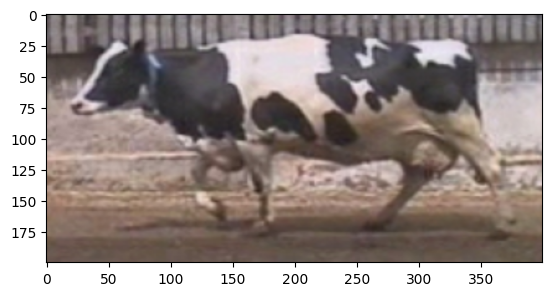

 
loading image cows/V00043.png...
For image 44, the most similar image is: 43.


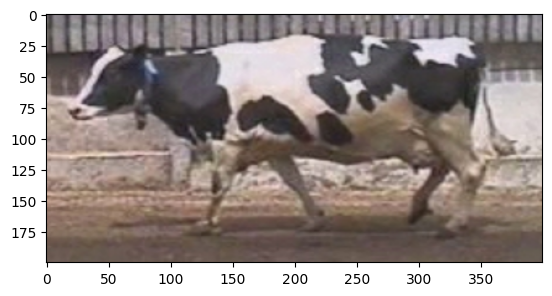

--------------------------------------------------
loading image cows/V00054.png...
Testing Imag: 54


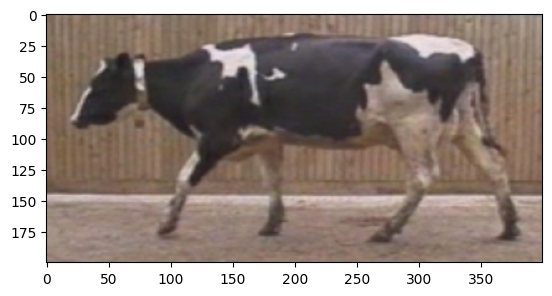

 
loading image cows/V00055.png...
For image 54, the most similar image is: 55.


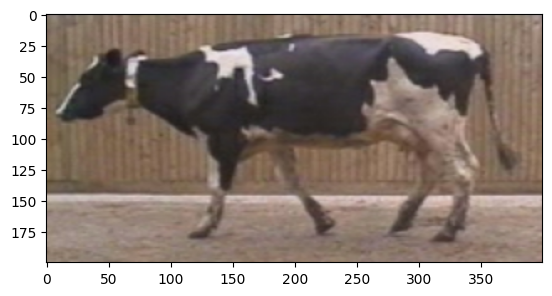

--------------------------------------------------
loading image cows/V00064.png...
Testing Imag: 64


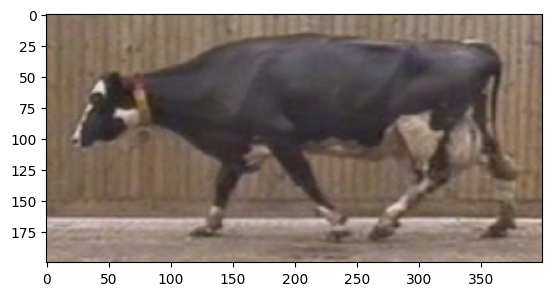

 
loading image cows/V00065.png...
For image 64, the most similar image is: 65.


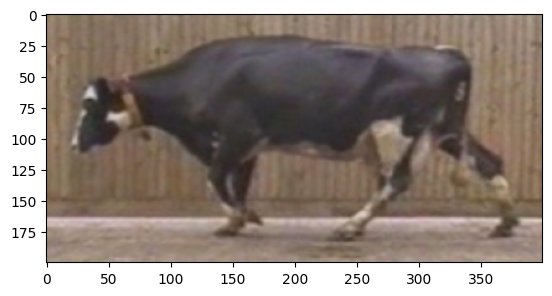

--------------------------------------------------
loading image cows/V00074.png...
Testing Imag: 74


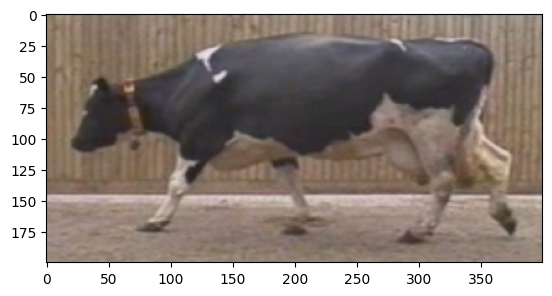

 
loading image cows/V00070.png...
For image 74, the most similar image is: 70.


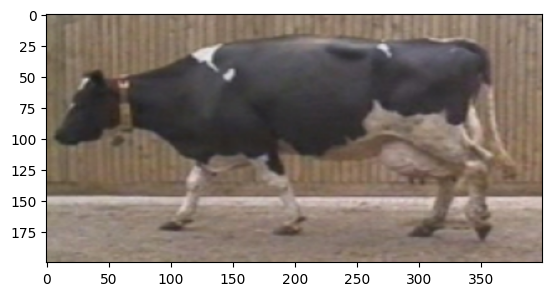

--------------------------------------------------


In [ ]:
for itest in [4,14,24,34,44,54,64,74]:

  ik = itest - 1  # first cow id is stores as 0
  ii = np.where(y==ik)[0] # testing indices
  jj = np.where(y!=ik)[0] # training indices

  Xi = X[ii,:] # testing SIFT
  Xj = X[jj,:] # training SIFT
  yj = y[jj]   # number of image to which non-test descriptors belong

  Dt = np.dot(Xj,Xi.T)

  n = Xi.shape[0]


  # For each descriptor in the testing image, we search for 1) the descriptor in the most similar training,
  # and 2) the value of the dot product with this vector

  z = np.zeros((n,))
  d = np.zeros((n,))

  for k in range(n):
      h    = Dt[:,k];        # h is the dot product of the descriptor of keypoint k of the testing with all the descriptors of the training.
      i    = h.max()         # i is the maximum dot product (i.e. with the training descriptor most similar to the testing descriptor k).
      z[k] = i
      j    = np.where(h==i)  # j is the index of the best product dot
      d[k] = yj[j]           # this is the number of the image to which the closest training descriptor belongs

  # Search for those training descriptors that are very similar to testing descriptors.
  kk = np.where(z>0.9)

  # The most frequent training image is calculated, i.e. the image containing the highest number of similar descriptors.
  m = stats.mode(d[kk])
  ifound = np.int(m[0])+1    # it is added to 1 because class 0 belongs to the image1

  I = ImageLoad('cows/V',itest,echo='on')

  print('Testing Imag: '+str(itest))
  plt.imshow(I,cmap='gray')
  plt.show()
  print(' ')
  J = ImageLoad('cows/V',ifound,echo='on')
  print('For image '+str(itest)+', the most similar image is: '+str(ifound)+'.')
  plt.imshow(J,cmap='gray')
  plt.show()
  print('--------------------------------------------------')
